In [75]:
from numpy.random import seed
seed(123)
#from tensorflow import set_random_seed
#set_random_seed(234)

import sklearn
from sklearn import datasets
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import decomposition
import scipy

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Layer, InputSpec, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras import regularizers, activations, initializers, constraints, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.constraints import UnitNorm, Constraint

import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [76]:
#f = lambda x,y:x**2/(x**2+x*y)
f = lambda x:np.sin(x)

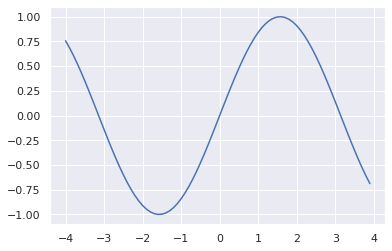

In [77]:
x = np.arange(-4, 4, 0.1)
y = f(x)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x,y)

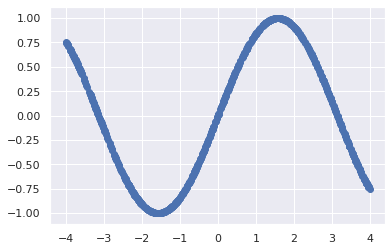

In [78]:
# Training Data (Without Noise)
x_train = np.random.uniform(-4, 4, 1000)
y_train = f(x_train)

train_in = np.array([x_train]).T
train_out = np.array([y_train]).T

# Test data
x_test = np.linspace(-4, 4, 10000)
y_test = f(x_test)
#xx_test, yy_test = np.meshgrid(x_test,y_test)
test_in = np.array([x_test]).T

# Preprocess
#X_train, X_test = train_test_split(X, test_size=0.01, random_state=123)
#scaler = StandardScaler() #Translate data and scale them such that stddev is 1
#scaler.fit(X_train)
#X_train_scaled = scaler.transform(X_train)
#X_test_scaled = scaler.transform(X_test)

# Plot Training Data
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x_train, y_train)

In [79]:
# Set up
nb_epoch = 100 #Number of runs
batch_size = 2
input_dim = 1 #Number of predictor variables,
learning_rate = 1e-2

# Batch and shuffle data
train_ds = tf.data.Dataset.from_tensor_slices(
    (train_in, train_out)).shuffle(100).batch(batch_size)

# Optimizer
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)

# Baseline

We first build a neural network consisting of 2 layers. The first layer contains multiples nodes with rectilinear activation, and the second layer combines (weighted sum) the outputs from the first layer to a single output. In this first example, we use a layer with 3 rectilinear nodes to approximate a single period of a sine function. i.e. find a piece-wise representation of the sine function using 3 rectilinear functions. 

While not shown here, a linear activation function will not work since summing multiple linear functions results in a linear function. The flat part of the rectilinear function defines the range where each node is no longer modeling the sine function, which means we can combine multiple ReLU functions to create a piece-wise function. A sigmoidal activation function works even better by specifying the lower and upper limit beyond which the node no longer has any effect. However, having large ranges where the activation function is flat means the nodes can't learn the proper weights and biases when the input data is in the flat region. Leaky ReLU, as we will who later, offers the benefit of faster training compared to ReLU.

To generate piecewise non-linearity, as long as the activation function has some form of non-linearity, it can be used to approximate any function theoretically. Different types of activation function will be better at learning specific types of functions, have different learning rates and affected differently by random initializations.

To be done: 
1. Plot loss over epoch
1. Show results from multiple initializations to show the success rate 


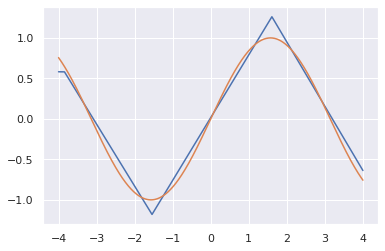

In [82]:
tf.keras.backend.clear_session()
model = Sequential()
model.add(Dense(3, activation='relu', input_dim=1))
model.add(Dense(1, activation='linear'))
model.compile(optimizer=opt, loss='mse')
model.fit(train_ds, epochs= 50, verbose=0)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_test, model.predict(test_in).T[0])
ax.plot(x_test, y_test)

# Leaky ReLU

Here, we show the fitting results using a leaky ReLU. 

To be done
1. Show learning rate compared to ReLU alone.

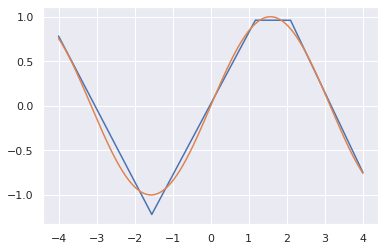

In [85]:
tf.keras.backend.clear_session()
model = Sequential()
model.add(Dense(3, activation='relu', input_dim=1))
model.add(LeakyReLU(alpha=0.03))
model.add(Dense(1, activation='linear'))
model.compile(optimizer=opt, loss='mse')
model.fit(train_ds, epochs= 50, verbose=0)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_test, model.predict(test_in).T[0])
ax.plot(x_test, y_test)

# Increasing depth

The previous models contain a layer with 3 nodes, which produces a piece-wise linear fit that uses approximately three linear regions. 
1. Does the model produce a better fit as we increase depth?  Yes
1. Should we expect the piece-wise linear fit to contain more pieces as depth increases? Yes

However, a model that is deeper than 4 layers sometimes produces a curious result where the model produces a single straight line at y=0. Increasing depth creates more parameters, and which increases the possibility of an initialization that breaks the model. Another problem with increasing depth is vanishing gradient.

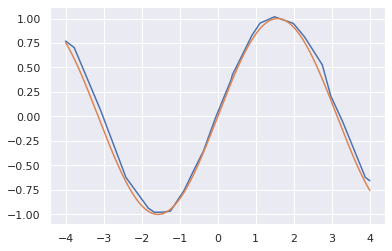

In [105]:
tf.keras.backend.clear_session()
model = Sequential()
model.add(Dense(3, activation='relu', input_dim=1))
model.add(LeakyReLU(alpha=0.03))
for i in range(10):
    model.add(Dense(3, activation='relu'))
    #model.add(LeakyReLU(alpha=0.03))
model.add(Dense(1, activation='linear'))
model.compile(optimizer=opt, loss='mse')
model.fit(train_ds, epochs= 50, verbose=0)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_test, model.predict(test_in).T[0])
ax.plot(x_test, y_test)

# Increasing width
Increasing layer width is essentially increasing the number of linear pieces used to fit the data. The higher the width, the better the fit. The figure below is a perfect illustration of how a neural network is able to approximate any function using only simple activation functions. 

By using a 33-nodes wide layer, I am introducing the same number of parameters as a model with 11 layers that are 3 nodes wide (as is the case above). Clearly, by increasing width, I get a much better fit for the same number of parameters. We will explore in a separate tutorial on the effects of width and depth when the data is noisy.

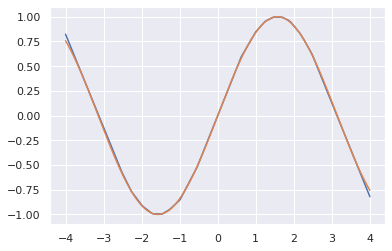

In [108]:
tf.keras.backend.clear_session()
model = Sequential()
model.add(Dense(33, activation='relu', input_dim=1))
model.add(LeakyReLU(alpha=0.03))
model.add(Dense(1, activation='linear'))
model.compile(optimizer=opt, loss='mse')
model.fit(train_ds, epochs= 50, verbose=0)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_test, model.predict(test_in).T[0])
ax.plot(x_test, y_test)

# Thoughts and future work
1. Can the network be trained to perform DFT, i.e. learn frequency components?
1. Interpret the meaning behind the weights and values at each layer.
1. How does the fit change in the presence of noisy data?